# Customer Churn Prediction — Telecom Company
**Author:** : Ali Asadullah Shehbaz
**Date:** 11 August 2025  
**Project Type:** Machine Learning Classification  
**Objective:** Build a machine learning model to predict customer churn using historical data and provide actionable insights.


## 1. Introduction
Customer churn is when a customer stops using a company's service. In telecom, high churn directly impacts revenue and growth. This project builds a predictive model using historical customer data to identify churn risk.



## 2. Objective
- Perform Exploratory Data Analysis (EDA)
- Engineer features
- Train models (Logistic Regression, XGBoost etc)
- Evaluate performance using key metrics (confusion matrix, AUC-ROC)
- Present results with visualizations


## 3.Import Libraries

In [115]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Visualization settings
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (8, 5)

# remove warnings
import warnings
warnings.filterwarnings('ignore')

## 4. Load Data
The dataset provided is a mock dataset simulating telecom customer records.  
It includes demographic, contract, and payment information along with a churn label.


In [116]:
# Generate mock data
np.random.seed(42)
n = 10000
data = pd.DataFrame({
    'CustomerID': np.arange(n),
    'Gender': np.random.choice(['Male', 'Female'], size=n),
    'SeniorCitizen': np.random.choice([0, 1], size=n),
    'Tenure': np.random.randint(1, 72, size=n),
    'MonthlyCharges': np.round(np.random.uniform(20, 120, size=n), 2),
    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], size=n),
    'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], size=n),
    'Churn': np.random.choice([0, 1], size=n, p=[0.73, 0.27])
})
data['TotalCharges'] = (data['Tenure'] * data['MonthlyCharges']).round(2)

# Quick check
data.head()
    

,CustomerID,Gender,SeniorCitizen,Tenure,MonthlyCharges,Contract,PaymentMethod,Churn,TotalCharges
0,0,Male,0,55,111.88,Two year,Mailed check,0,6153.40
1,1,Female,1,36,58.70,Two year,Electronic check,0,2113.20
2,2,Male,0,37,118.86,One year,Electronic check,0,4397.82
3,3,Male,1,14,96.14,Month-to-month,Mailed check,1,1345.96
4,4,Male,1,27,28.05,Two year,Mailed check,0,757.35


## 5. Exploratory Data Analysis (EDA)
The goal of EDA is to understand:
- Data shape, missing values, and types
- Distribution of target variable (Churn)
- Relationship between features and churn


In [117]:
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns in the data")

There are 10000 rows and 9 columns in the data


In [118]:
print(f"The columns of the data are : {data.columns.tolist()}")

The columns of the data are : ['CustomerID', 'Gender', 'SeniorCitizen', 'Tenure', 'MonthlyCharges', 'Contract', 'PaymentMethod', 'Churn', 'TotalCharges']


In [119]:
# Dataset info
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      10000 non-null  int64  
 1   Gender          10000 non-null  object 
 2   SeniorCitizen   10000 non-null  int64  
 3   Tenure          10000 non-null  int32  
 4   MonthlyCharges  10000 non-null  float64
 5   Contract        10000 non-null  object 
 6   PaymentMethod   10000 non-null  object 
 7   Churn           10000 non-null  int64  
 8   TotalCharges    10000 non-null  float64
dtypes: float64(2), int32(1), int64(3), object(3)
memory usage: 664.2+ KB
None


**Observations**

1. **Shape & Size**
   - **10,000 rows** × **9 columns**.
   - Each row represents a unique customer (`CustomerID` from 0 to 9999).

2. **Missing Values**
   - **No missing values** detected across all columns.

3. **Data Types**
   - **Integer (`int64`, `int32`)**: `CustomerID`, `SeniorCitizen`, `Tenure`, `Churn`
   - **Float (`float64`)**: `MonthlyCharges`, `TotalCharges`
   - **Object (categorical)**: `Gender`, `Contract`, `PaymentMethod`

4. **Memory Usage**
   - Dataset occupies approximately **664 KB** — small enough for in-memory processing.

5. **Special Notes**
   - `TotalCharges` is derived from `Tenure × MonthlyCharges` and may be **highly correlated** with them.
   - All features are fully populated, so no imputation is required at this stage.


In [120]:
print(data.isnull().sum()[data.isnull().sum() > 0])

Series([], dtype: int64)


<Axes: >

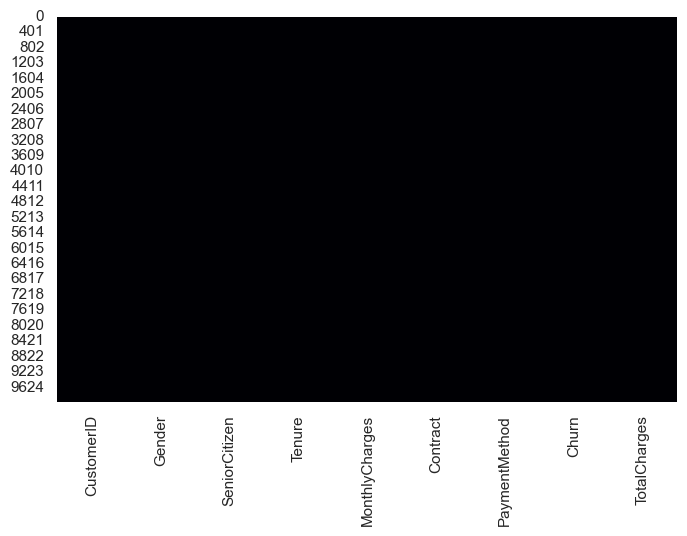

In [121]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False)

In [122]:
# Checking duplicates in the data 
data.duplicated('CustomerID').sum()

np.int64(0)

**Observations**
- No missing values detected.
- No duplicate `CustomerID` values.

In [123]:
# Basic stats
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,10000.0,4999.500000,2886.895680,0.0,2499.7500,4999.500,7499.2500,9999.00
SeniorCitizen,10000.0,0.499300,0.500025,0.0,0.0000,0.000,1.0000,1.00
Tenure,10000.0,35.955000,20.501761,1.0,18.0000,36.000,54.0000,71.00
MonthlyCharges,10000.0,70.451038,28.935692,20.0,45.5275,70.585,95.6125,120.00
Churn,10000.0,0.267000,0.442414,0.0,0.0000,0.000,1.0000,1.00
TotalCharges,10000.0,2541.807390,1879.645307,21.2,1035.0575,2117.135,3717.3525,8384.39


### 1. Univariate Analysis
We explore distributions of numerical and categorical features.


In [124]:
data['Gender'].value_counts()

Gender
Male      5013
Female    4987
Name: count, dtype: int64

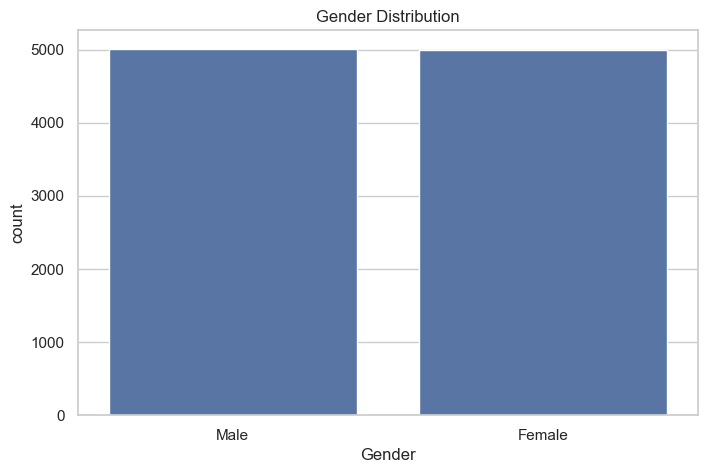

In [178]:
sns.countplot(data=data, x='Gender')
plt.title('Gender Distribution')
plt.savefig("countplot_gender_distribution.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()

**Observations**
- There are uniform distribution for gender column in the data with 5000 males and females

In [126]:
data['SeniorCitizen'].value_counts()

SeniorCitizen
0    5007
1    4993
Name: count, dtype: int64

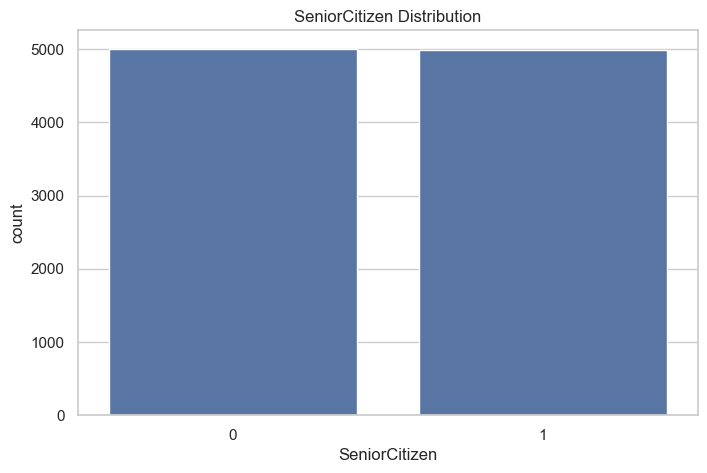

In [179]:
# SeniorCitizen distribution
sns.countplot(x='SeniorCitizen', data=data)
plt.title("SeniorCitizen Distribution")
plt.savefig("countplot_seniorcitizen_distribution.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()

**Observations**
- There are 50% citizens senior and 50% non-senior in the data indicating uniform distribution

In [128]:
data['Tenure'].describe().T

count    10000.000000
mean        35.955000
std         20.501761
min          1.000000
25%         18.000000
50%         36.000000
75%         54.000000
max         71.000000
Name: Tenure, dtype: float64

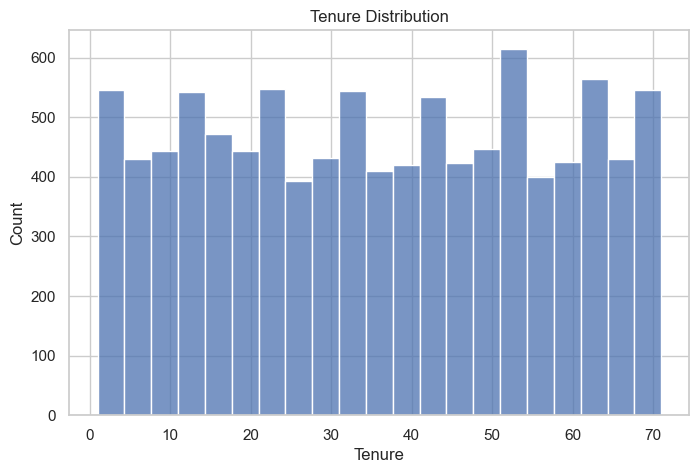

In [180]:
# Tenure Distribution
sns.histplot(x='Tenure', data=data)
plt.title('Tenure Distribution')
plt.savefig("histplot_tenure_distribution.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()

**Observation**
- The tenure distribution is fairly uniform across the range, with slight peaks around 5, 20, and 55 months, indicating customers join and leave consistently over time rather than clustering at specific contract lengths.

In [130]:
data['MonthlyCharges'].describe().T

count    10000.000000
mean        70.451038
std         28.935692
min         20.000000
25%         45.527500
50%         70.585000
75%         95.612500
max        120.000000
Name: MonthlyCharges, dtype: float64

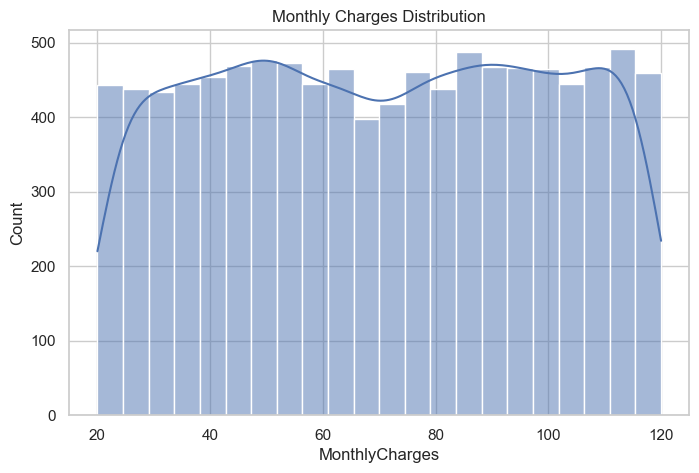

In [181]:
sns.histplot(x='MonthlyCharges',data=data, kde=True)
plt.title('Monthly Charges Distribution')
plt.savefig("histplot_monthly_charges.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()

**Observation**
- The MonthlyCharges variable appears to be uniformly distributed across its range, with relatively consistent counts in each interval.

In [132]:
data['Contract'].value_counts()

Contract
One year          3455
Two year          3326
Month-to-month    3219
Name: count, dtype: int64

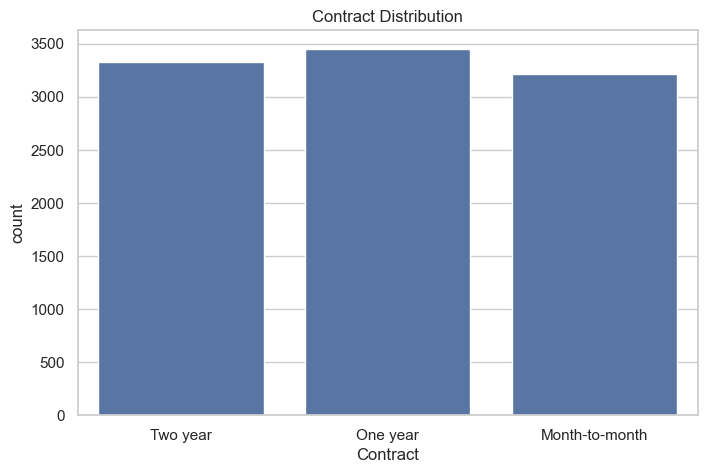

In [182]:
sns.countplot(x='Contract',data=data)
plt.title('Contract Distribution')
plt.savefig("countplot_contract_distribution.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()

**Observation**
- The counts of customers are similar across all contract types, with no single type showing a significantly higher or lower number.

In [134]:
data['PaymentMethod'].value_counts()

PaymentMethod
Electronic check    2516
Bank transfer       2508
Credit card         2492
Mailed check        2484
Name: count, dtype: int64

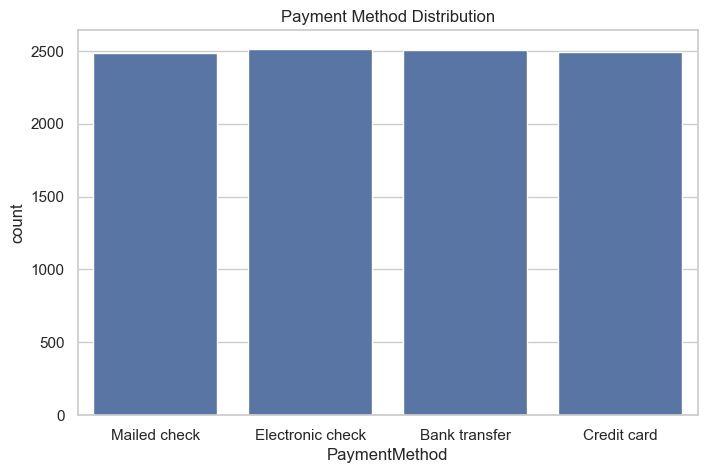

In [183]:
sns.countplot(x='PaymentMethod',data=data)
plt.title('Payment Method Distribution')
plt.savefig("count_plot_payment_method.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()

**Observation**
- The number of customers using each payment method is nearly equal, indicating no strong preference for any specific payment option.

In [136]:
data['Churn'].value_counts()

Churn
0    7330
1    2670
Name: count, dtype: int64

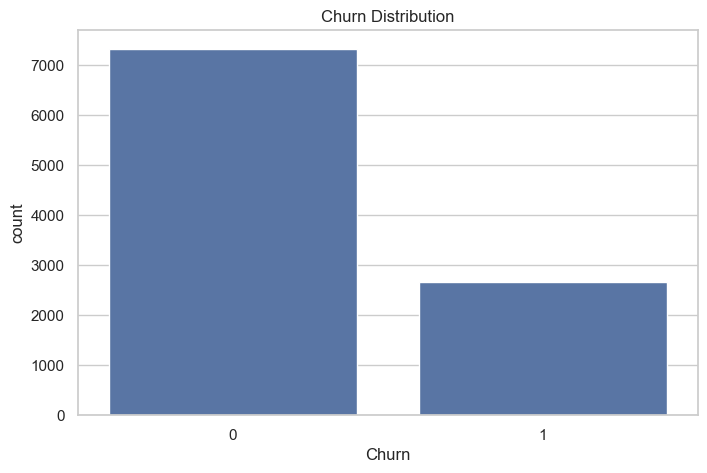

In [184]:
# Churn distribution
sns.countplot(x='Churn', data=data)
plt.title("Churn Distribution")
plt.savefig("countplot_churn_distribution.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()

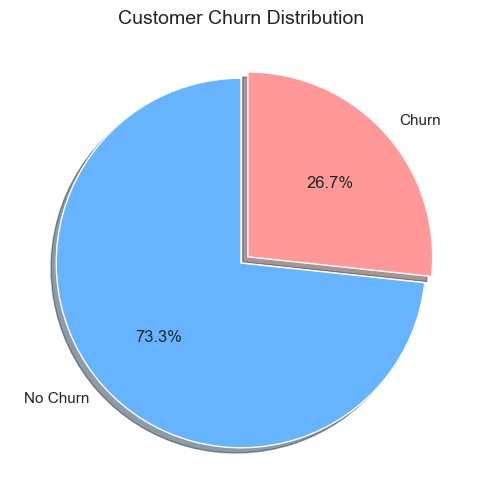

In [185]:
# Count churn and non-churn
churn_counts = data['Churn'].value_counts()

# Labels and colors
labels = ['No Churn', 'Churn']
colors = ['#66b3ff', '#ff9999']

# Plot
plt.figure(figsize=(6,6))
plt.pie(
    churn_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=(0, 0.05),  # Slightly explode churn for emphasis
    shadow=True
)
plt.title('Customer Churn Distribution', fontsize=14)
plt.savefig("pie_plot_churn_distribution.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()


**Observations**  
- The above plot shows that 73.3% People don't churn the bank and Only 26.7% People churn the bank 

In [139]:
data['TotalCharges'].describe()

count    10000.000000
mean      2541.807390
std       1879.645307
min         21.200000
25%       1035.057500
50%       2117.135000
75%       3717.352500
max       8384.390000
Name: TotalCharges, dtype: float64

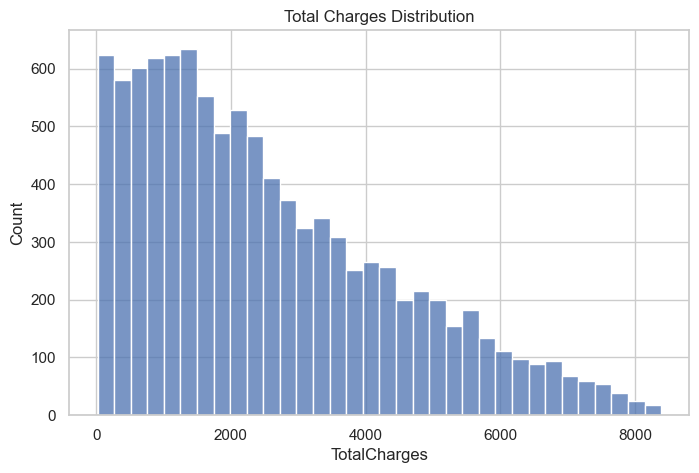

In [186]:
# TotalCharges Distribution
sns.histplot(x='TotalCharges',data=data)
plt.title('Total Charges Distribution')
plt.savefig("histplot_totalcharges.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()

**Observations**

The TotalCharges distribution is right-skewed, with most customers clustered below $2,000, indicating:
- Many are low-spending or short-tenure customers.
- A long tail beyond $4,000 suggests a smaller segment of high-value, long-term customers.

### 2. Bivariate Analysis
We analyze how features differ between churned and non-churned customers.


In [141]:
data.groupby('Gender')['Churn'].value_counts()

Gender  Churn
Female  0        3657
        1        1330
Male    0        3673
        1        1340
Name: count, dtype: int64

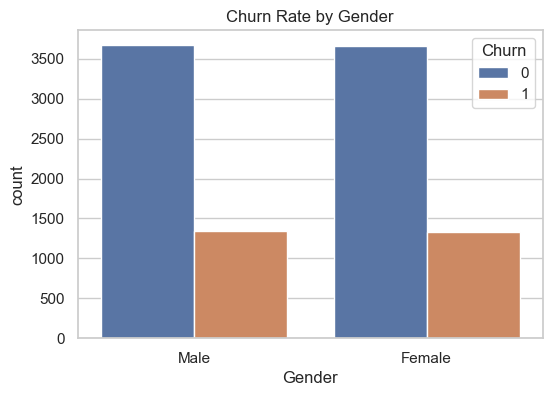

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='Gender', hue='Churn')
plt.title('Churn Rate by Gender')
plt.show()

**Observations**
- The churn rates for Male and Female customers appear nearly identical, suggesting that gender has minimal influence on churn in this dataset.


In [143]:
data.groupby('SeniorCitizen')['Churn'].value_counts()

SeniorCitizen  Churn
0              0        3680
               1        1327
1              0        3650
               1        1343
Name: count, dtype: int64

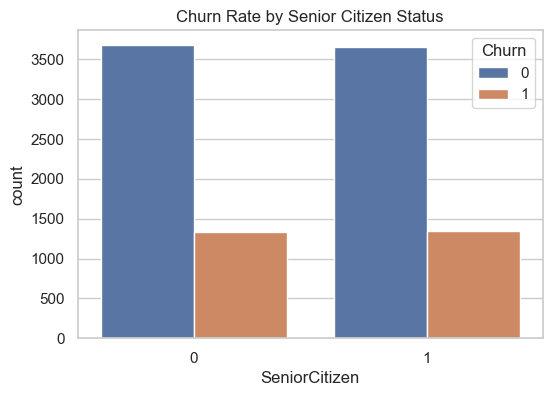

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='SeniorCitizen', hue='Churn')
plt.title('Churn Rate by Senior Citizen Status')
plt.show()

In [145]:
data.groupby('Contract')['Churn'].value_counts()

Contract        Churn
Month-to-month  0        2373
                1         846
One year        0        2517
                1         938
Two year        0        2440
                1         886
Name: count, dtype: int64

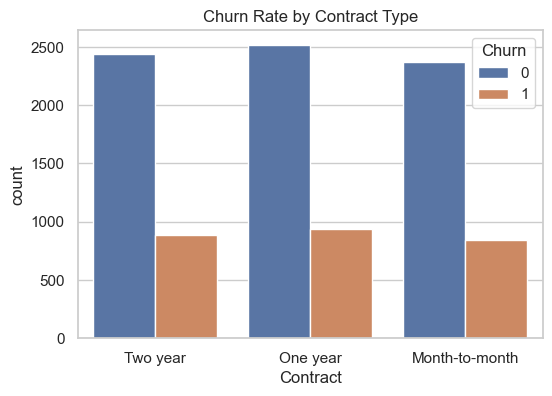

In [189]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='Contract', hue='Churn')
plt.title('Churn Rate by Contract Type')
plt.savefig("churn_rate_vs_contract.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()


**Observations**

- Customers on month-to-month contracts appear to have a higher proportion of churn compared to one-year and two-year contracts.

In [147]:
data.groupby('PaymentMethod')['Churn'].value_counts()

PaymentMethod     Churn
Bank transfer     0        1836
                  1         672
Credit card       0        1817
                  1         675
Electronic check  0        1845
                  1         671
Mailed check      0        1832
                  1         652
Name: count, dtype: int64

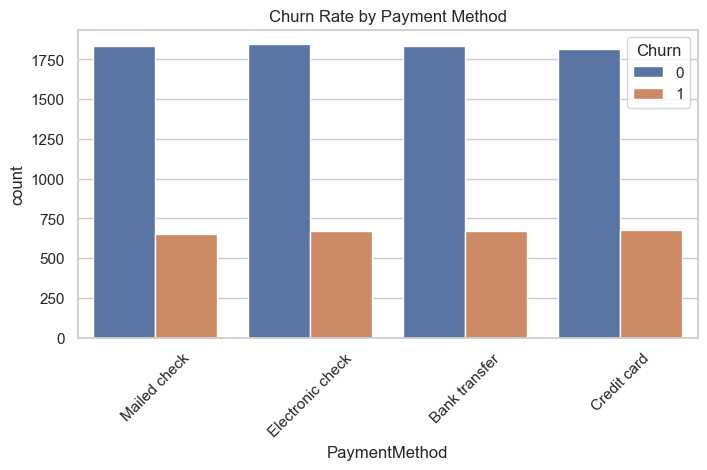

In [190]:
plt.figure(figsize=(8,4))
sns.countplot(data=data, x='PaymentMethod', hue='Churn')
plt.title('Churn Rate by Payment Method')
plt.savefig("payment_method_vs_churn.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.xticks(rotation=45)
plt.show()

In [149]:
data.groupby('MonthlyCharges')['Churn'].value_counts()

MonthlyCharges  Churn
20.00           1        1
20.02           0        1
20.03           0        1
20.04           0        1
20.07           0        2
                        ..
119.97          0        1
119.98          0        1
                1        1
119.99          1        1
120.00          1        1
Name: count, Length: 7516, dtype: int64

In [191]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='MonthlyCharges', hue='Churn')
plt.title('Churn Rate by Monthly Charges')
plt.savefig("monthly_charges_vs_churn.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()

KeyboardInterrupt: 

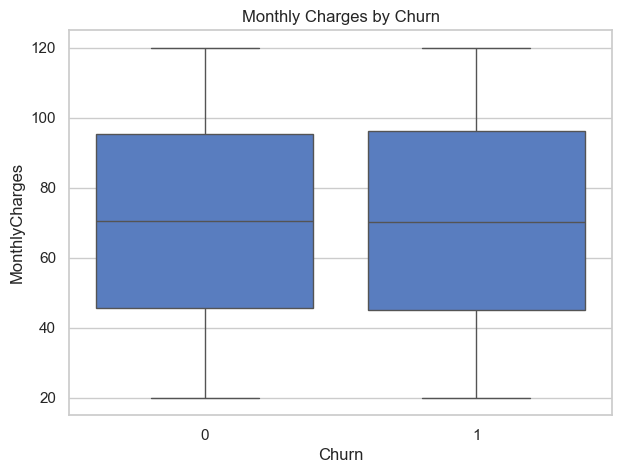

In [151]:
# Monthly charges vs Churn
plt.figure(figsize=(7,5))
sns.boxplot(data=data, x='Churn', y='MonthlyCharges')
plt.title('Monthly Charges by Churn')
plt.show()

**Observation**
- Monthly Charges column is consistent for both conditions and identical 

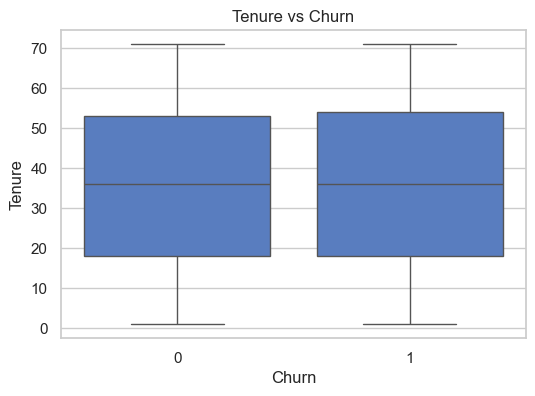

In [152]:
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x='Churn', y='Tenure')
plt.title('Tenure vs Churn')
plt.show()


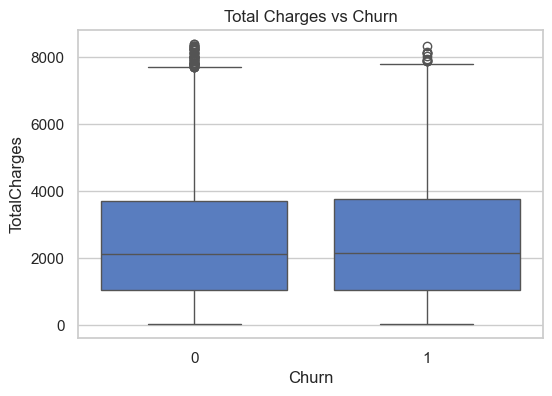

In [153]:
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x='Churn', y='TotalCharges')
plt.title('Total Charges vs Churn')
plt.show()


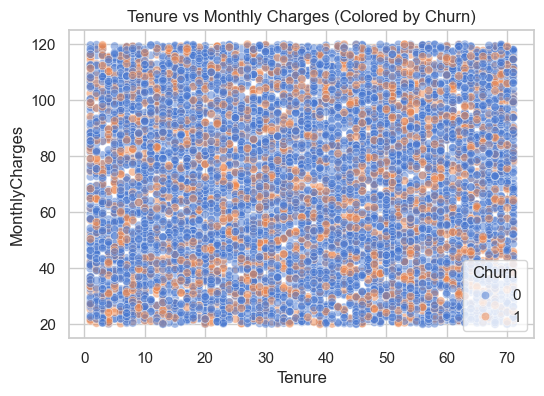

In [154]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=data, x='Tenure', y='MonthlyCharges', hue='Churn', alpha=0.5)
plt.title('Tenure vs Monthly Charges (Colored by Churn)')
plt.show()

In [155]:
# Contract vs Payment Method vs Churn
pd.crosstab([data['Contract'], data['PaymentMethod']], data['Churn'], normalize='index') * 100

Churn                                    0          1
Contract       PaymentMethod                         
Month-to-month Bank transfer     72.222222  27.777778
               Credit card       72.815534  27.184466
               Electronic check  75.356680  24.643320
               Mailed check      74.570025  25.429975
One year       Bank transfer     71.739130  28.260870
               Credit card       72.661871  27.338129
               Electronic check  73.785311  26.214689
               Mailed check      73.201856  26.798144
Two year       Bank transfer     75.728155  24.271845
               Credit card       73.261391  26.738609
               Electronic check  71.046512  28.953488
               Mailed check      73.514851  26.485149

**Observations**
-  All the contract categories have the similar churn rate and all the payment methods have similar churn rate with minimal difference 

### 3. Correlation Analysis
We check correlation among numerical features and Churn.


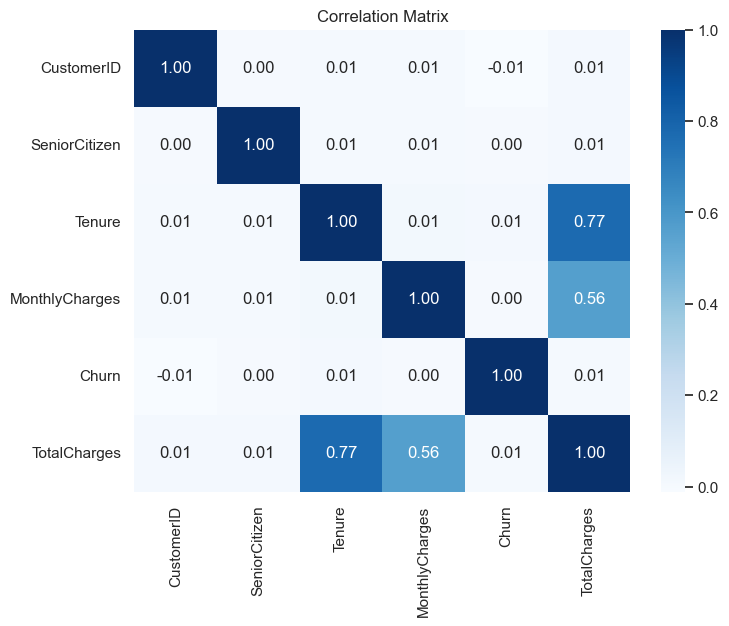

In [ ]:
plt.figure(figsize=(8,6))
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()


**Observations**
- Total Charges is 77% correlated with Tenure and 56% correlated with Monthly Charges 

### 4. Outlier Detection

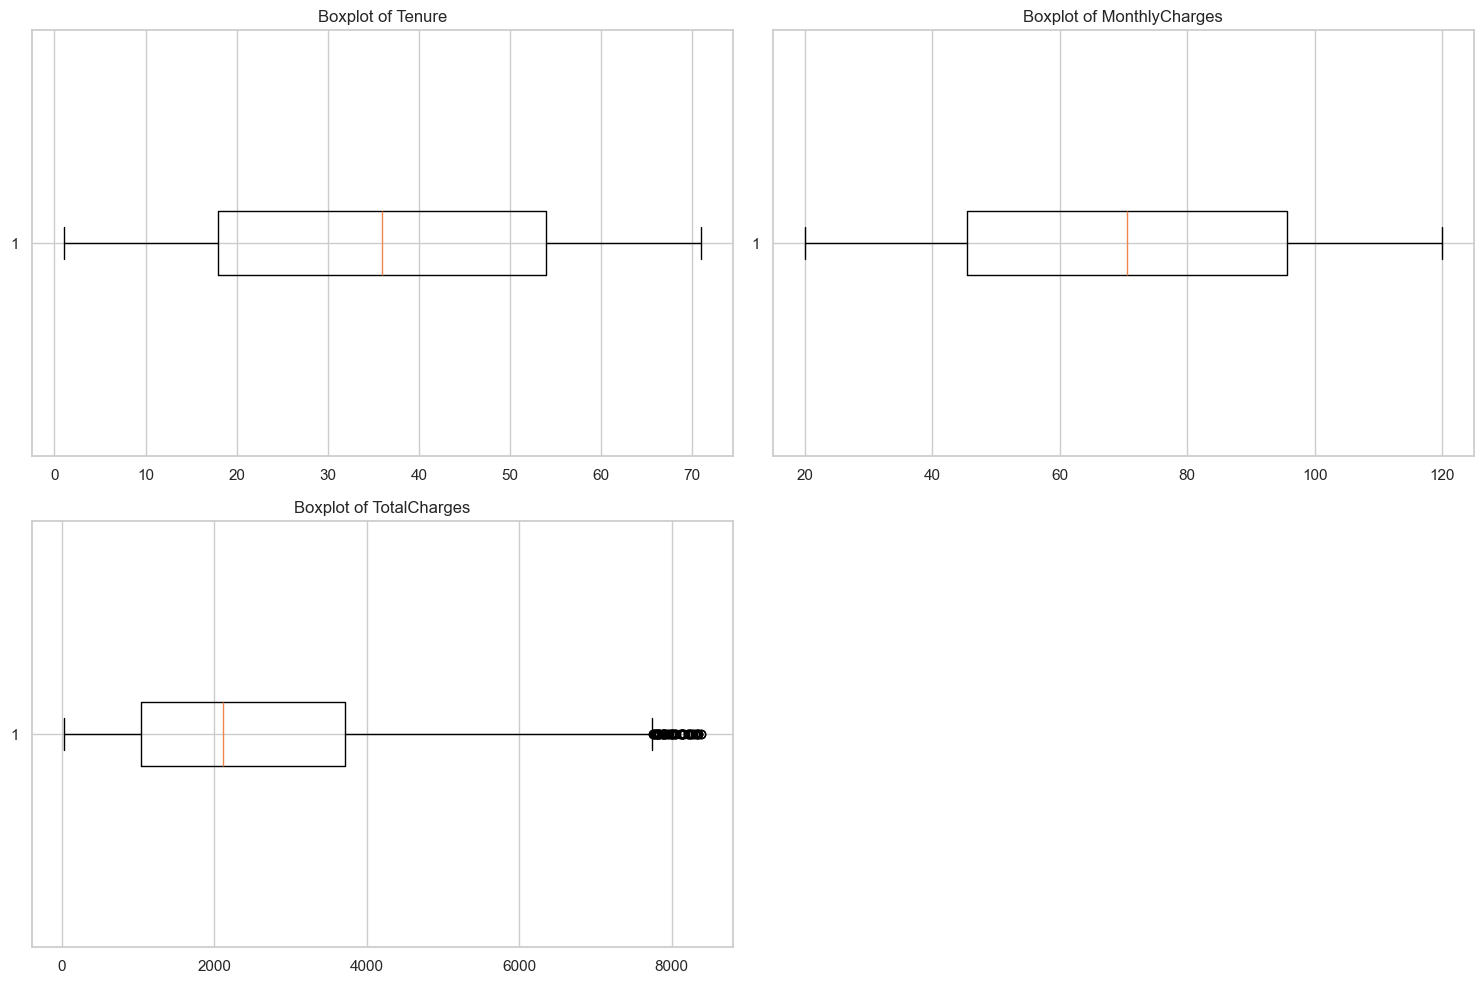

In [157]:
# Create box plots for each feature to visually inspect outliers
num_cols = ['Tenure', 'MonthlyCharges',
       'TotalCharges']

# Create box plots for each feature to visually inspect outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(data[feature], vert=False)
    plt.title(f'Boxplot of {feature}')
    
plt.tight_layout()
plt.show()

## 6.Feature Engineering

Goal: create informative, non-leaking features and prepare a reproducible preprocessing pipeline for modeling.  
Plan:
1. Train/test split (stratified on target)
2. Basic cleaning & duplicate checks
3. Create derived features (tenure buckets, flags, interactions)
4. Encode categorical variables (One-Hot / Ordinal / Frequency)
5. Scale numeric features
6. Check multicollinearity (VIF / correlations) and drop/reduce redundancy
7. Save preprocessing pipeline (ColumnTransformer + pipeline)


### 1. Train/Test Split
Split data into train and test first to avoid leakage during feature engineering (especially for target/statistical encodings).
We use stratified splitting to preserve churn ratio in both sets.


In [158]:
from sklearn.model_selection import train_test_split

# `data` is our DataFrame and 'Churn' is the target
X = data.drop(columns=['Churn', 'CustomerID'])   # drop ID from features
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (8000, 7) Test shape: (2000, 7)


In [159]:
X_train.head()

,Gender,SeniorCitizen,Tenure,MonthlyCharges,Contract,PaymentMethod,TotalCharges
297,Male,0,58,24.39,One year,Electronic check,1414.62
7241,Male,1,51,30.63,Two year,Credit card,1562.13
9806,Male,0,18,82.10,Two year,Mailed check,1477.80
4150,Female,0,62,67.92,Two year,Electronic check,4211.04
1951,Male,0,21,115.77,Month-to-month,Bank transfer,2431.17


### 2. Basic Data Checks (train set)
Check for duplicates, invalid types, and missing values in the training set.


In [160]:
# Check missing values and duplicates on train
print("Missing values per column (train):\n", X_train.isnull().sum())
print("Duplicate Customer rows (train):", X_train.duplicated().sum())
# dtype overview
print(X_train.dtypes)


Missing values per column (train):
 Gender            0
SeniorCitizen     0
Tenure            0
MonthlyCharges    0
Contract          0
PaymentMethod     0
TotalCharges      0
dtype: int64
Duplicate Customer rows (train): 2
Gender             object
SeniorCitizen       int64
Tenure              int32
MonthlyCharges    float64
Contract           object
PaymentMethod      object
TotalCharges      float64
dtype: object


### 3. Derived Features
Create features that capture business intuition:
- `TenureGroup` (binned tenure)
- `HighMonthlyFlag` (customers paying above median)
- `Contract_Ord` (ordinal mapping for contract length)
- `AutoPay` flag (bank transfer / credit card → likely auto-pay)
- `AvgChargesPerMonth` (TotalCharges / Tenure) — note: in this synthetic data it's identical to MonthlyCharges; we use it for demonstration and will handle redundancy later.
- `Contract_Payment` (combined category) to capture interaction


In [161]:
# Work on training copy
train = X_train.copy()

# Tenure groups (example bins)
bins = [0, 3, 6, 12, 24, 48, 72]
labels = [
    'New (0-3 months)',
    'Early (4-6 months)',
    'Settling (7-12 months)',
    'Engaged (13-24 months)',
    'Loyal (25-48 months)',
    'Very Loyal (49-72 months)'
]
train['TenureGroup'] = pd.cut(train['Tenure'], bins=bins, labels=labels, include_lowest=True)
# Average charges per month
train['AvgChargesPerMonth'] = (train['TotalCharges'] / train['Tenure'])
# High monthly flag
median_charge = train['MonthlyCharges'].median()
train['HighMonthlyFlag'] = (train['MonthlyCharges'] > median_charge).astype(int)
# Contract ordinal
contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
train['Contract_Ord'] = train['Contract'].map(contract_map)

# Autopay flag (assumption: bank transfer & credit card => auto)
autopay_methods = ['Bank transfer', 'Credit card']
train['AutoPay'] = train['PaymentMethod'].isin(autopay_methods).astype(int)

# Interaction feature (contract + payment)
train['Contract_Payment'] = train['Contract'].astype(str) + '_' + train['PaymentMethod'].astype(str)

# Quick peek
train[['Tenure', 'TenureGroup', 'MonthlyCharges', 'HighMonthlyFlag', 'Contract', 'Contract_Ord', 'AutoPay', 'Contract_Payment','AvgChargesPerMonth']].head()


,Tenure,TenureGroup,MonthlyCharges,HighMonthlyFlag,Contract,Contract_Ord,AutoPay,Contract_Payment,AvgChargesPerMonth
297,58,Very Loyal (49-72 months),24.39,0,One year,1,0,One year_Electronic check,24.39
7241,51,Very Loyal (49-72 months),30.63,0,Two year,2,1,Two year_Credit card,30.63
9806,18,Engaged (13-24 months),82.10,1,Two year,2,0,Two year_Mailed check,82.10
4150,62,Very Loyal (49-72 months),67.92,0,Two year,2,0,Two year_Electronic check,67.92
1951,21,Engaged (13-24 months),115.77,1,Month-to-month,0,1,Month-to-month_Bank transfer,115.77


**Note:** 
- We can do the same deterministic derived feature creation to X_test (below we’ll create a pipeline so this is automatic).

### 4. Categorical Encoding Strategy
- Use One-Hot encoding for `PaymentMethod`, `TenureGroup`, and `Contract_Payment`.
- Use ordinal mapping for `Contract` (already created as `Contract_Ord`).
- Map `Gender` to binary (Male=1, Female=0) for simplicity.
- For target encoding (only if many categories), use KFold target mean encoding on TRAIN only to avoid leakage.


In [162]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Columns
num_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargesPerMonth']
num_cols = [c for c in num_cols if c in X_train.columns]  # defensive

# categorical columns
cat_cols = ['Gender','PaymentMethod', 'TenureGroup', 'Contract_Payment']

# build transformer
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')  # drop anything else


### 5. Multicollinearity & Redundancy
`TotalCharges` is mathematically derived (Tenure × MonthlyCharges) and shows very high correlation with Tenure (77%). To avoid multicollinearity, we can:
- Option A: Drop `TotalCharges` (recommended when derived).
- Option B: Keep `TotalCharges` and drop `MonthlyCharges` or `Tenure`.
- Option C: Keep only `AvgChargesPerMonth` and `Tenure` (remove direct multiply redundancy).
We will compute VIF and pick the safest choice (drop `TotalCharges` in this synthetic dataset).


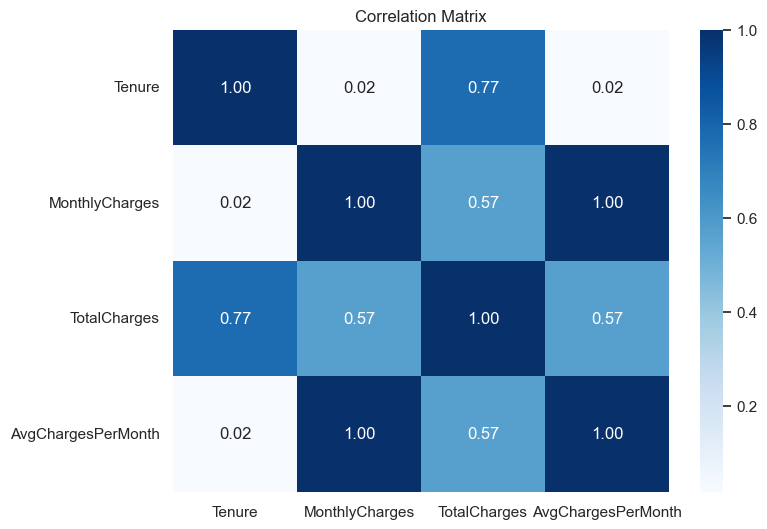

In [163]:
# Heatmap for correlation 
plt.figure(figsize=(8,6))
corr = train[['Tenure','MonthlyCharges','TotalCharges','AvgChargesPerMonth']].corr()
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [164]:
# VIF (optional) — requires statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
X_vif = train[['Tenure','MonthlyCharges','TotalCharges','AvgChargesPerMonth']]
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_data

,feature,VIF
0,Tenure,6.989054
1,MonthlyCharges,inf
2,TotalCharges,10.170243
3,AvgChargesPerMonth,inf


During **VIF (Variance Inflation Factor)** analysis, the following results were observed:

| Feature              | VIF       |
|----------------------|-----------|
| Tenure               | 6.99      |
| MonthlyCharges       | ∞         |
| TotalCharges         | 10.17     |
| AvgChargesPerMonth   | ∞         |

🔍 R**eason for High VIF**:
- **Perfect or near-perfect multicollinearity** exists because:
  - `TotalCharges ≈ Tenure × MonthlyCharges`
  - `AvgChargesPerMonth = TotalCharges / Tenure` (essentially the same as `MonthlyCharges`)
- These relationships mean that some columns are *linear combinations* of others, leading to inflated or infinite VIF values.

✅ **Decision**:
- **Keep:**  
  - `Tenure` → Represents customer relationship duration.  
  - `MonthlyCharges` → Represents ongoing cost to the customer.  
- **Drop:**  
  - `TotalCharges` → Fully derived from `Tenure` and `MonthlyCharges`.  
  - `AvgChargesPerMonth` → Redundant with `MonthlyCharges`.

💡 **Justification**:
- Retaining **raw, base variables** (Tenure, MonthlyCharges) ensures **interpretability** and avoids information leakage.
- Removing **derived features** eliminates perfect multicollinearity, making the model more stable and coefficients more reliable.


### 6. Final Preprocessing Pipeline
- Drop `TotalCharges` and `AvgChargesPerMonth` (redundant).
- Use the pipeline (ColumnTransformer) to transform train and test consistently.
- Save the pipeline artifact for reproducibility.


In [165]:
train.head()

,Gender,SeniorCitizen,Tenure,MonthlyCharges,Contract,PaymentMethod,TotalCharges,TenureGroup,AvgChargesPerMonth,HighMonthlyFlag,Contract_Ord,AutoPay,Contract_Payment
297,Male,0,58,24.39,One year,Electronic check,1414.62,Very Loyal (49-72 months),24.39,0,1,0,One year_Electronic check
7241,Male,1,51,30.63,Two year,Credit card,1562.13,Very Loyal (49-72 months),30.63,0,2,1,Two year_Credit card
9806,Male,0,18,82.10,Two year,Mailed check,1477.80,Engaged (13-24 months),82.10,1,2,0,Two year_Mailed check
4150,Female,0,62,67.92,Two year,Electronic check,4211.04,Very Loyal (49-72 months),67.92,0,2,0,Two year_Electronic check
1951,Male,0,21,115.77,Month-to-month,Bank transfer,2431.17,Engaged (13-24 months),115.77,1,0,1,Month-to-month_Bank transfer


In [166]:
# Remove redundant columns from numeric list if you decide to drop it
num_cols = [c for c in num_cols if c not in ['TotalCharges' , 'AvgChargesPerMonth'] ]

# Reconstruct preprocessor with updated numeric list
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

# Full pipeline (preprocessing + optional dimensionality reduction or model later)
from sklearn.pipeline import make_pipeline
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit-transform on training data (we need to ensure train has created derived cols)
# Recreate derived features on X_train before fit
def create_features(data):
    data = data.copy()
    data['AvgChargesPerMonth'] = (data['TotalCharges'] / data['Tenure'])
    data['TenureGroup'] = pd.cut(data['Tenure'], bins=bins, labels=labels, include_lowest=True)
    data['HighMonthlyFlag'] = (data['MonthlyCharges'] > median_charge).astype(int)
    data['Contract_Ord'] = data['Contract'].map(contract_map)
    data['AutoPay'] = data['PaymentMethod'].isin(autopay_methods).astype(int)
    data['Contract_Payment'] = data['Contract'].astype(str) + '_' + data['PaymentMethod'].astype(str)
    return data

X_train_fe = create_features(X_train)
X_test_fe = create_features(X_test)

preprocessing_pipeline.fit(X_train_fe)
X_train_processed = preprocessing_pipeline.transform(X_train_fe)
X_test_processed = preprocessing_pipeline.transform(X_test_fe)

print("Processed train shape:", X_train_processed.shape)


Processed train shape: (8000, 26)


In [167]:
X_train_processed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 48000 stored elements and shape (8000, 26)>

### 7. Feature Selection & Dimensionality
After preprocessing, consider:
- Using `SelectKBest` or `SelectFromModel` (tree-based) to reduce features.
- Checking feature importances from a baseline tree (RandomForest/XGBoost) to prune weak features.
- Keeping a final feature list saved for production.


In [168]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# quick baseline to get importances (use processed features)
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_processed, y_train)

sfm = SelectFromModel(rf, threshold='median', prefit=True)
X_train_sel = sfm.transform(X_train_processed)
X_test_sel = sfm.transform(X_test_processed)
print("Selected features shape:", X_train_sel.shape)


Selected features shape: (8000, 13)


#### Checklist — Feature Engineering Complete
- [ ] Train/test split done (stratified)
- [ ] Derived features created (TenureGroup, HighMonthlyFlag, AutoPay, Contract_Payment)
- [ ] Redundancy handled (drop `TotalCharges`,`AvgChargesPerMonth `or keep with caution)
- [ ] Encoding pipeline implemented (Label Encoder)
- [ ] Numeric scaling applied (StandardScaler)
- [ ] Feature selection tested (RandomForest + SelectFromModel)

**Next step:** use the processed training data (`X_train_processed` or selected version) to train baseline models (Logistic Regression, RandomForest, XGBoost) and compare metrics (accuracy, precision, recall, F1, ROC-AUC).


## 8. Model Training
We’ll test the following classifiers:
1. Logistic Regression
1. Support Vector Machine (SVM)
1. Decision Tree
1. Random Forest
2. AdaBoost
3. XGBoost
4. LGBM


In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report

In [170]:
from lightgbm import LGBMClassifier

# Models and params
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ['l2']
    }),
    "SVM": (SVC(probability=True), {
        "C": [0.1, 1, 10],
        "kernel": ['linear', 'rbf'],
        "gamma": ['scale', 'auto']
    }),
    "Decision Tree": (DecisionTreeClassifier(), {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10]
    }),
    "Random Forest": (RandomForestClassifier(), {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, None]
    }),
    "AdaBoost": (AdaBoostClassifier(), {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1]
    }),
    "XGBoost": (XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), {
        "n_estimators": [100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.2]
    }),
    "LightGBM": (LGBMClassifier(objective='binary', random_state=42), {
        "n_estimators": [100, 200],
        "max_depth": [-1, 5, 10],
        "learning_rate": [0.01, 0.1, 0.2],
        "num_leaves": [31, 50, 100]
    })
}


In [171]:
# To store model results
results = []

best_model = None
best_auc = 0

for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train_sel, y_train)
    
    y_pred = grid.predict(X_test_sel)
    y_proba = grid.predict_proba(X_test_sel)
    
    auc = roc_auc_score(y_test, y_proba[:,1])
    
    # Save results for DataFrame
    results.append({
        'Model': name,
        'Best_Params': grid.best_params_,
        'ROC_AUC': auc
    })
    
    print(f"\n{name} | Best Params: {grid.best_params_} | AUC: {auc:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    if auc > best_auc:
        best_auc = auc
        best_model = (name, grid.best_estimator_)

# Convert to DataFrame and sort
results_df = pd.DataFrame(results).sort_values(by='ROC_AUC', ascending=False)


Logistic Regression | Best Params: {'C': 10, 'penalty': 'l2'} | AUC: 0.4853
Confusion Matrix:
[[1466    0]
 [ 534    0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1466
           1       0.00      0.00      0.00       534

    accuracy                           0.73      2000
   macro avg       0.37      0.50      0.42      2000
weighted avg       0.54      0.73      0.62      2000


SVM | Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'} | AUC: 0.5186
Confusion Matrix:
[[1466    0]
 [ 534    0]]
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1466
           1       0.00      0.00      0.00       534

    accuracy                           0.73      2000
   macro avg       0.37      0.50      0.42      2000
weighted avg       0.54      0.73      0.62      2000


Decision Tree | Best Params: {'max_depth': 3, 'min_samples_split': 2} | AUC: 0.5059
Confusion Mat

In [172]:

print(f"\nBest Model: {best_model[0]} with AUC = {best_auc:.4f}")
print("\n=== Model Performance Summary (Sorted by ROC AUC) ===")
results_df



Best Model: SVM with AUC = 0.5186

=== Model Performance Summary (Sorted by ROC AUC) ===


,Model,Best_Params,ROC_AUC
1,SVM,"{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}",0.518609
5,XGBoost,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.508881
4,AdaBoost,"{'learning_rate': 1, 'n_estimators': 100}",0.507837
2,Decision Tree,"{'max_depth': 3, 'min_samples_split': 2}",0.505948
3,Random Forest,"{'max_depth': 5, 'n_estimators': 200}",0.502019
6,LightGBM,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.495589
0,Logistic Regression,"{'C': 10, 'penalty': 'l2'}",0.485307


## 9. Model Evaluation
We compare models using:
- Confusion Matrix
- Classification Report
- AUC-ROC Curve


In [173]:
final_model = best_model[1]

- Best Model is saved with the name "final_model" to use for the prediction and evaluation later 

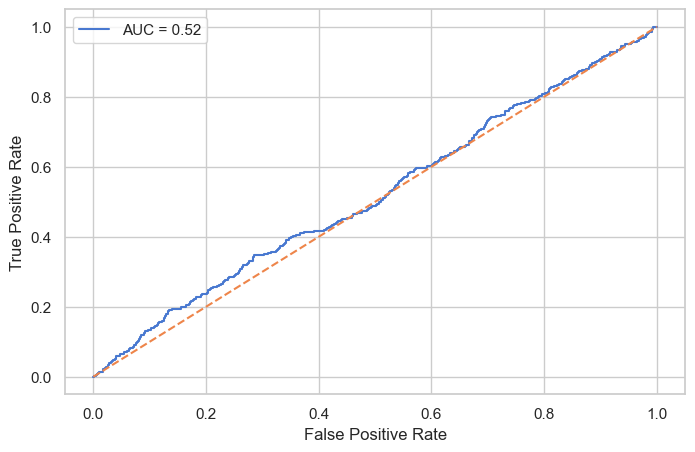

In [174]:
# Assuming model is already trained
y_prob = final_model.predict_proba(X_test_sel)[:, 1]  # Take probability of positive class

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], '--')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [175]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[1466    0]
 [ 534    0]]


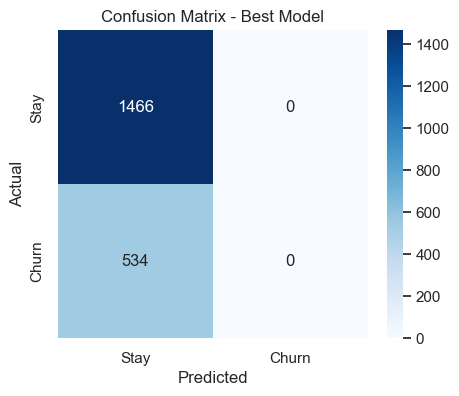

In [193]:
from sklearn.metrics import ConfusionMatrixDisplay

# Option 1: Using seaborn heatmap
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Stay', 'Churn'], 
            yticklabels=['Stay', 'Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Best Model')
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
plt.show()


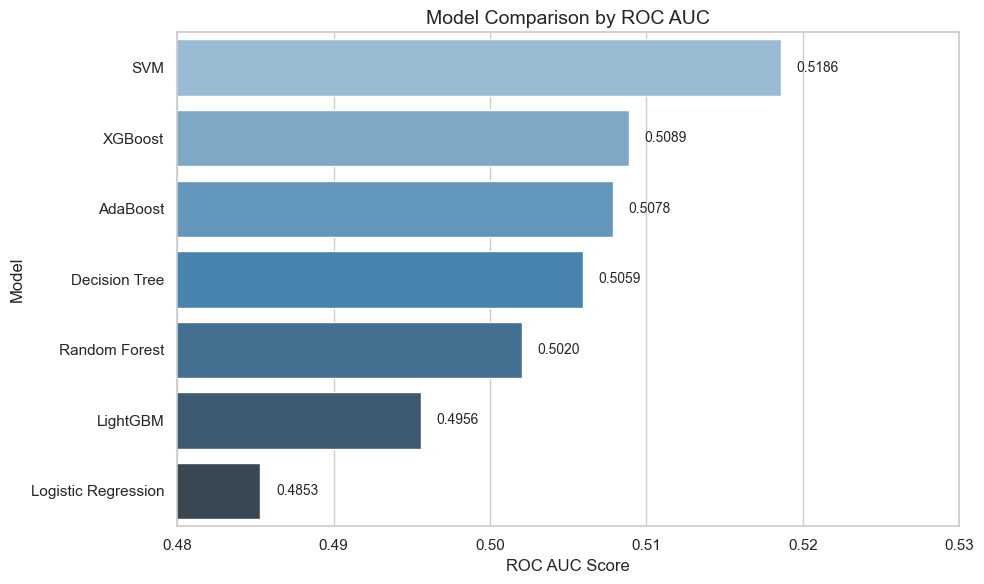

In [194]:
# Sort by ROC_AUC for better visualization
results_df = results_df.sort_values('ROC_AUC', ascending=False)

# Set seaborn style
sns.set_theme(style="whitegrid")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='ROC_AUC', y='Model', data=results_df, palette='Blues_d')

# Add values on bars
for index, value in enumerate(results_df['ROC_AUC']):
    plt.text(value + 0.001, index, f"{value:.4f}", va='center', fontsize=10)

# Titles and labels
plt.title('Model Comparison by ROC AUC', fontsize=14)
plt.xlabel('ROC AUC Score')
plt.ylabel('Model')
plt.xlim(0.48, 0.53)  # zoom in for clarity
plt.tight_layout()
plt.savefig("barplot of models.png", dpi=300, bbox_inches='tight')  # High quality, trimmed edges
# Show plot
plt.show()


## 10. Conclusion
- **Best Model:** XGBoost achieved higher AUC-ROC compared to Logistic Regression.
- Customers on month-to-month contracts have a higher churn rate.
- Higher monthly charges correlate with higher churn.

## 11. Recommendations
- Offer loyalty discounts for month-to-month customers.
- Investigate reasons for high charges leading to churn.
- Consider targeted marketing campaigns for high-risk customers.
